In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
def jaccard_similarity(row):
    string1, string2 = row.st_orig, row.st_pred
    
    wordset = lambda x: set(x.lower().split())
    a, b = wordset(string1), wordset(string2)

    c = a.intersection(b)

    return float(len(c)) / (len(a) + len(b) - len(c))

def string_length(s):
    return len(s)

def num_words(s):
    return len(s.split())

In [78]:
train = pd.read_csv("../data/train.csv")
submission = pd.read_csv("../roberta/submission_2020.05.10.11.39.csv")
merged = (train
          .merge(submission, on="textID")
          .rename({"selected_text_x": "st_orig", "selected_text_y": "st_pred"}, axis="columns")
          .assign(
              text=lambda x: x.text.str.lower(),
              st_orig=lambda x: x.st_orig.str.lower(),
              st_pred=lambda x: x.st_pred.str.lower(),
              jaccard=lambda x: x.apply(jaccard_similarity, axis=1),
              text_len=lambda x: x.text.apply(string_length),
              st_orig_len=lambda x: x.st_orig.apply(string_length),
              st_pred_len=lambda x: x.st_pred.apply(string_length),
              text_words=lambda x: x.text.apply(num_words),
              st_orig_words=lambda x: x.st_orig.apply(num_words),
              st_pred_words=lambda x: x.st_pred.apply(num_words),
          )
         )

In [84]:
train.iloc[1]

textID                                               549e992a42
text              Sooo SAD I will miss you here in San Diego!!!
selected_text                                          Sooo SAD
sentiment                                              negative
Name: 1, dtype: object

In [79]:
print(f"Overall jaccard score: {merged.jaccard.mean():.4f}")
merged.groupby("sentiment", as_index=False)["jaccard"].mean().sort_values("jaccard")

Overall jaccard score: 0.7551


,sentiment,jaccard
2,positive,0.597026
0,negative,0.610914
1,neutral,0.978007


In [31]:
print(f"Overall jaccard score: {merged.jaccard.mean():.4f}")
merged.groupby("sentiment", as_index=False)["jaccard"].mean().sort_values("jaccard")

Overall jaccard score: 0.7586


,sentiment,jaccard
2,positive,0.602713
0,negative,0.617113
1,neutral,0.977996


In [72]:
sns.regplot(x="start_softmax", y="jaccard", data=merged, ax=ax, x_bins=10, lowess=True)

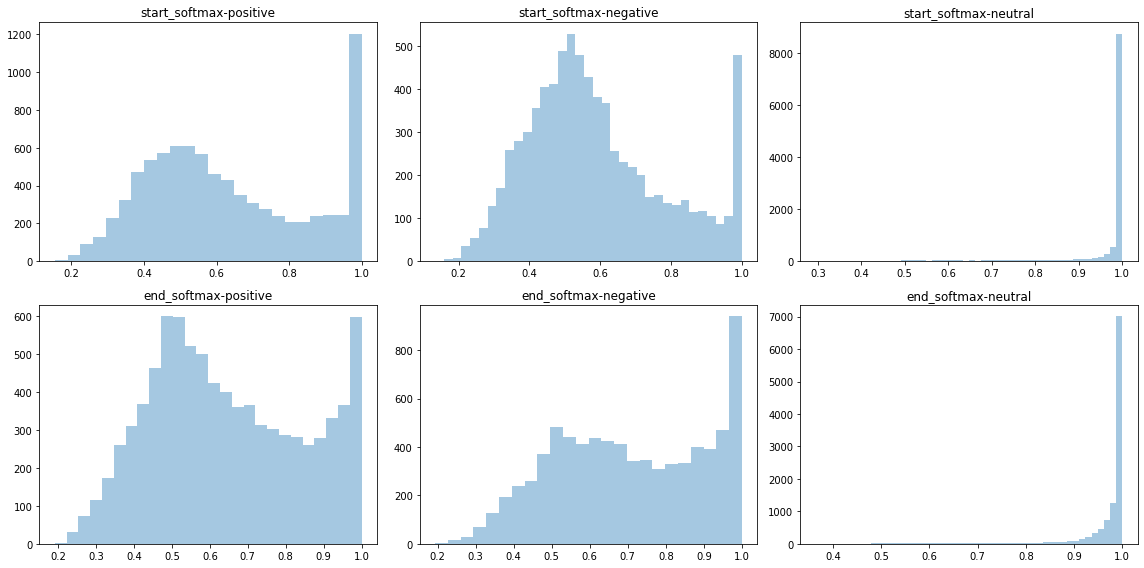

In [65]:
f, axes = plt.subplots(2, 3, figsize=(16, 8))

for label_type, row in zip(("start_softmax", "end_softmax"), axes):
    for sentiment, ax in zip(("positive", "negative", "neutral"), row):
        values = list(merged.query("sentiment==@sentiment")[label_type].values)
        sns.distplot(values, kde=False, ax=ax)
        ax.set_title(f"{label_type}-{sentiment}")

plt.tight_layout()

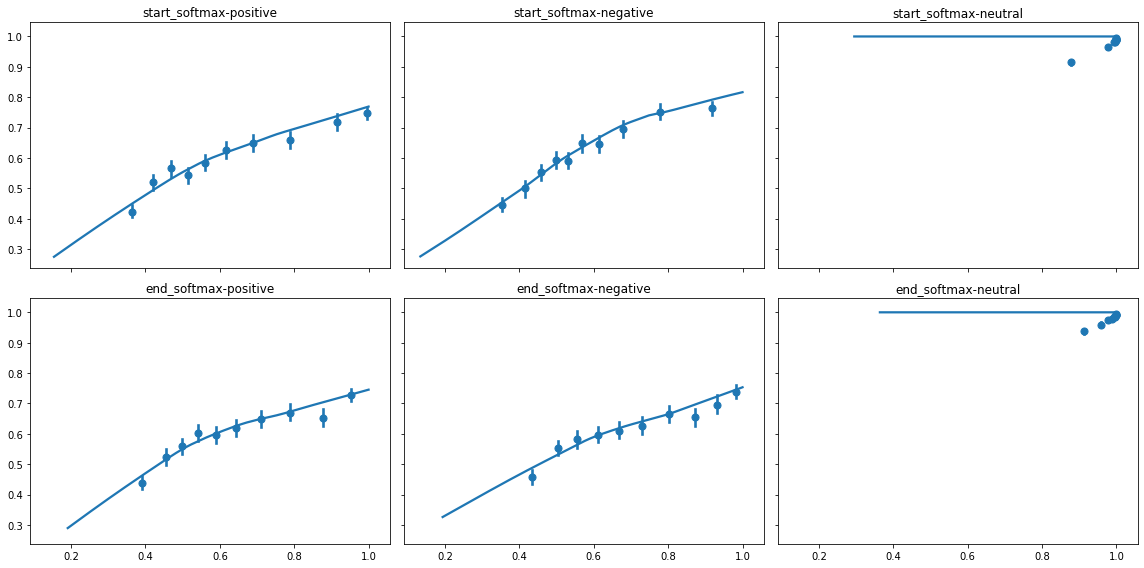

In [71]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)

for label_type, row in zip(("start_softmax", "end_softmax"), axes):
    for sentiment, ax in zip(("positive", "negative", "neutral"), row):
        x = list(merged.query("sentiment==@sentiment")[label_type].values)
        y = list(merged.query("sentiment==@sentiment")["jaccard"].values)
        sns.regplot(x=x, y=y, ax=ax, x_bins=10, lowess=True)
        ax.set_title(f"{label_type}-{sentiment}")
#         ax.set_xlabel("softmax")
#         ax.set_ylabel("jaccard")

plt.tight_layout()